In [34]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [35]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [36]:
#scaling the data
def scale_data(data):
    image = data['image']
    return image/255

In [37]:
#load, map, cache, shuffle, batch, prefetch
#reload the data and follow the steps for preprocessing
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_data) #scaleing the images
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(32)

In [38]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [40]:
def build_generator():
    model = Sequential([
        # Takes in random values and reshapes it to 7x7x128
        Dense(7*7*128, input_dim=128),
        LeakyReLU(0.2),
        Reshape((7, 7, 128)),
        
        # For upsampling block 1
        UpSampling2D(),
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),
        
        # Conv layer 1
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),

        # Conv layer 2
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),

        # For upsampling block 2
        UpSampling2D(),
        Conv2D(128, 4, padding='same'),
        LeakyReLU(0.2),

        # Conv layer 3
        Conv2D(128, 4, padding='same'),
        LeakyReLU(0.2),

        # Conv layer 4
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),
        
        # Final Conv layer
        Conv2D(1, 4, padding='same', activation='sigmoid')
    ])
    
    return model

In [41]:
generator = build_generator()

In [42]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

In [43]:
import numpy as np

1/1 [==============================] - 0s 36ms/step
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


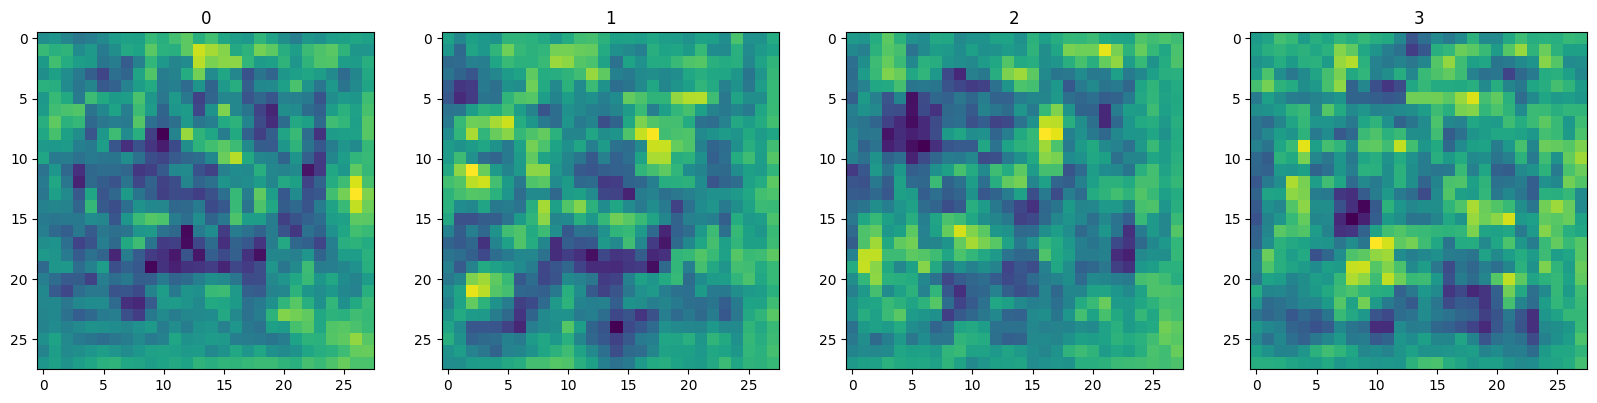

In [75]:
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    print(img.shape)
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

In [66]:
from tensorflow.keras.layers import MaxPooling2D

In [67]:
def build_discriminator():
    model = Sequential()

    # First Conv Layer
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=(28, 28, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Second Conv Layer
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Third Conv Layer
    model.add(Conv2D(256, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Fourth Conv Layer
    model.add(Conv2D(512, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Flatten and Output Layer
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [68]:
discriminator = build_discriminator()

In [69]:
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 4, 4, 256)         295168    
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 4, 4, 256)         0         
                                                                 
 conv2d_37 (Conv2D)          (None, 2, 2, 512)        

In [90]:
img2 = generator.predict(np.random.randn(4,128,1))
discriminator.predict(img2)

1/1 [==============================] - 0s 312ms/step


array([[0.50249594],
       [0.50246495],
       [0.5025211 ],
       [0.50250095]], dtype=float32)

In [91]:
# Most Important part of GANs is balancing the generator and discriminator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [92]:
g_opt = Adam(learning_rate=1e-4)
d_opt = Adam(learning_rate=1e-5)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [93]:
from tensorflow.keras.models import Model

In [94]:
tf.random.normal((6,128,1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[ 1.13738096e+00],
        [ 1.24820814e-01],
        [-1.61678538e-01],
        [-8.89505327e-01],
        [ 3.47689837e-01],
        [-4.23696131e-01],
        [ 4.61970031e-01],
        [ 6.08404279e-01],
        [ 3.97962406e-02],
        [ 2.09848022e+00],
        [ 6.13968968e-01],
        [ 6.21858478e-01],
        [-9.23696280e-01],
        [ 2.86087215e-01],
        [-1.34256110e-01],
        [-9.78454053e-01],
        [ 8.14421713e-01],
        [ 1.56504023e+00],
        [ 4.67203230e-01],
        [ 6.16953492e-01],
        [ 8.31258297e-01],
        [-9.55439687e-01],
        [ 8.12014118e-02],
        [-6.23295188e-01],
        [-1.19966710e+00],
        [-3.30526471e-01],
        [-6.77798763e-02],
        [-2.14151287e+00],
        [-2.79900372e-01],
        [ 2.87180543e-01],
        [ 5.96059747e-02],
        [ 1.69811678e+00],
        [ 1.31903350e+00],
        [ 1.11077535e+00],
        [-1.43896878e+00],
  

In [102]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator
        self.discriminator = discriminator
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
    def train_step(self, batch):
        real_img = batch
        fake_img = self.generator(tf.random.normal((6,128,1)), training=False)

        #train the discriminator
        with tf.GradientTape() as d_tape:
            #pass the real and fake images 
            yhat_real = self.discriminator(real_img, training=True)
            yhat_fake = self.discriminator(fake_img, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            #create labels for real and fake images 
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_real)], axis=0)
            
            #add some noise to the true outputs
            noise_real= 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake= -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            #calculate loss
            total_d_loss = self.d_loss(yhat_realfake, yhat_realfake)
            
        #apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        #train the generator
        with tf.GradientTape() as g_tape:
            #generate new images
            gen_img = self.generator(tf.random.normal((128,128,1)), training=True)
            #create predicted labels 
            predicted_labels = self.discriminator(gen_img, training=False)

            #calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
            
        #apply backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss": total_g_loss}

In [103]:
gan = GAN(generator=generator,discriminator=discriminator)

In [104]:
gan.compile(g_opt=g_opt, g_loss=g_loss, d_opt=d_opt, d_loss=d_loss)

In [105]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [110]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128, save_freq=5):
        super().__init__()
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_freq = save_freq  # Save every `save_freq` epochs

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.save_freq == 0:  # Save images every `save_freq` epochs
            random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim, 1))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images *= 255
            generated_images = generated_images.numpy()
            if not os.path.exists('images'):
                os.makedirs('images')
            for i in range(self.num_img):
                img = array_to_img(generated_images[i])
                img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [111]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [115]:
# Example usage with your GAN model
gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)
monitor = ModelMonitor(num_img=3, latent_dim=128, save_freq=1)
history = gan.fit(ds, epochs=5)

Epoch 1/5
469/469 [==============================] - 707s 2s/step - d_loss: 7.4903e-04 - g_loss: 6.1846
Epoch 2/5
469/469 [==============================] - 745s 2s/step - d_loss: 1.9223e-04 - g_loss: 7.6556
Epoch 3/5
469/469 [==============================] - 802s 2s/step - d_loss: 8.0167e-05 - g_loss: 8.6146
Epoch 4/5
469/469 [==============================] - 796s 2s/step - d_loss: 4.1254e-05 - g_loss: 9.3435
Epoch 5/5
469/469 [==============================] - 796s 2s/step - d_loss: 2.3821e-05 - g_loss: 9.9447


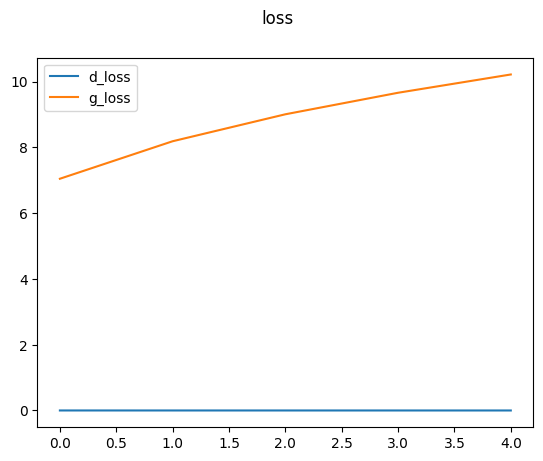

In [117]:
plt.suptitle('loss')
plt.plot(history.history['d_loss'], label='d_loss')
plt.plot(history.history['g_loss'], label='g_loss')
plt.legend()
plt.show()